Getting into the right folder and enviroment


In [89]:
from google.colab import drive
drive.mount('/content/drive')
FOLDER_NAME = 'Kaggle-ML/Neuromatch_Project'
FOLDER_PATH = f'drive/My Drive/{FOLDER_NAME}/'
%cd "{FOLDER_PATH}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Kaggle-ML/Neuromatch_Project/'
/content/drive/My Drive/Kaggle-ML/Neuromatch_Project


In [90]:
DATASET_ROOT = 'dataset'
TRAIN_FOLDER = f'{DATASET_ROOT}/Training'
TEST_FOLDER = f'{DATASET_ROOT}/Testing'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE= 4
TRAIN_NUM_WORKERS= 1
VAL_BATCH_SIZE= 4
VAL_NUM_WORKERS= 1
TEST_BATCH_SIZE= 4
TEST_NUM_WORKERS= 1
TRAIN_SIZE= 2476
VALIDATION_SIZE = 394

Installing dependencies

In [91]:
import torch,gc
import pathlib
import cv2 
import matplotlib.pyplot as plt 
import imutils
import time


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, models, utils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import time

In [92]:
# Setting the right device
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
device

device(type='cpu')

In [93]:
# Preprocessing: Cropping brain contour

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
           
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()

    return new_image

In [94]:
from numpy import dtype
# Defining custom dataset with augmentations
class CustomDataset(ImageFolder):
  def __init__(self, root, transforms):
    super(CustomDataset, self).__init__(root=root, transform=transforms)
    self.transform = transforms

  def __getitem__(self, index):
    image_path, target = self.samples[index]

    cv2_image = cv2.imread(image_path)
    cv2_image = crop_brain_contour(cv2_image, plot=False)

    # resize image
    cv2_image = cv2.resize(cv2_image, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
    # normalize values
    cv2_image= cv2_image/255

    sample = transforms.ToTensor()(cv2_image).float()

    if self.transform:
       sample = self.transform(sample)
    
    return sample, target

In [95]:
# To do Split here!!!!


# Data Augmentation using transforms
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(IMAGE_SIZE),
                                        transforms.RandomCrop(IMAGE_SIZE),                           
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.RandomRotation(degrees=(30, 70)),
                                        transforms.ToTensor(),
                                     ])


data_path = pathlib.Path('.')/'afhq'  # Using pathlib to be compatible with all OS's
dataset = CustomDataset(TRAIN_FOLDER, transforms=train_transforms)

In [96]:
test_ds = CustomDataset(TRAIN_FOLDER, transforms=None)

In [97]:
# Create random split of training vs validation
validation_ds, train_ds = torch.utils.data.random_split(dataset, [VALIDATION_SIZE,TRAIN_SIZE])

In [98]:
# Don't do transforms on validation DS
validation_ds.dataset.transform = None

In [99]:
# Train Dataloader
train_dataloader = DataLoader(
    train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
    num_workers=TRAIN_NUM_WORKERS, pin_memory=True
)

# Validation Dataloader
validation_dataloader = DataLoader(
    validation_ds, batch_size=VAL_BATCH_SIZE, shuffle=True,
    num_workers=VAL_NUM_WORKERS, pin_memory=True
)

# Test Dataloader
test_dataloader = DataLoader(
    test_ds, batch_size=TEST_BATCH_SIZE, shuffle=True,
    num_workers=TEST_NUM_WORKERS, pin_memory=True
)

In [100]:
#Dataloaders output a 4 dimensional tensor - [batch, channel, height, width]
batch = next(iter(train_dataloader))
train_images_batch, train_labels_batch = batch
print(f"Feature batch shape: {train_images_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")

Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])


In [101]:
batch = next(iter(train_dataloader))

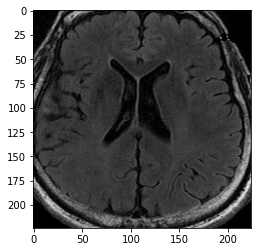

In [102]:
image = train_images_batch[0]
image = image.permute(1,2,0)
plt.imshow(image)

In [103]:
classes_training= dataset.class_to_idx
classes_training

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [104]:
classes = {}
for key,value in classes_training.items():
  classes[value] = key
classes

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

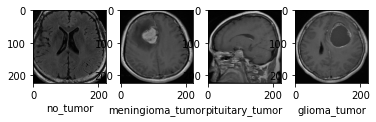

In [105]:
# Show a batch 
def show_batch(batch_images, batch_labels):
  batch,_,_,_ = batch_images.shape
  for i in range(batch):
    # plt subplot subplot(nrows, ncols, index, **kwargs)
    axes = plt.subplot(1,TRAIN_BATCH_SIZE,i+1)
    class_idx = batch_labels[i].item()
    label = classes[class_idx]
    axes.set(xlabel=label)
    plt.imshow(batch_images[i].permute(1,2,0))

  plt.show()

show_batch(train_images_batch, train_labels_batch)

# Implementing RESNET 
Credits to: https://www.kaggle.com/code/jarvisgroot/brain-tumor-classification-in-pytorch/notebook

In [106]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# print the trasnfer learning NN model's architecture
resnet_model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [107]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features
n_classes = 4

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, n_classes),
                                nn.LogSoftmax(dim=1))
                                #nn.LogSigmoid())

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [108]:
torch.cuda.empty_cache()

In [118]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.NLLLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=1e-12)

# number of training iterations
epochs = 5

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [ ]:
def save_checkpoint(state, is_best, filename='./resnet_50.tar'):
    torch.save(state, filename)


In [119]:
# Get a batch of training data
b_inputs, b_classes = next(iter(train_dataloader))
outputs = resnet_model(b_inputs)
outputs, outputs.shape

(tensor([[-0.8666, -1.4123, -2.2337, -1.4744],
         [-1.4671, -1.4697, -1.5578, -1.1122],
         [-1.3369, -0.9441, -1.9220, -1.5995],
         [-1.2864, -0.9795, -1.9155, -1.6046]], grad_fn=<LogSoftmaxBackward0>),
 torch.Size([4, 4]))

In [ ]:
# set training start time
start_time = time.time()
print('TRAINING STARTED')

# start training
for epoch in range(epochs):
    
    # set epoch's starting time
    e_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    # setting model to training mode
    resnet_model.train()

    # loss and accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0

    #trn_co
    
    # train in batches
    for batch, (inputs, labels) in enumerate(train_dataloader):
        # set label as cuda if device is cuda
        inputs = inputs.to(device)
        labels= labels.to(device)

        #Cleaning existing gradients
        optimizer.zero_grad()
          
        # forward pass image sample
        outputs = resnet_model(inputs)
        torch.cuda.empty_cache()
        
        # calculate loss
        loss = criterion(outputs, labels)

        # back propagate with loss
        loss.backward()
        
        # perform optimizer step
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # Compute accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
	      
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(batch, loss.item(), acc.item()))



        # #   # get argmax of predicted tensor, which is our label
        # predicted = torch.argmax(outputs, dim=1).data

        # #   # if predicted label is correct as true label, calculate the sum for samples
        # batch_corr = (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()
        # #   # increment train correct with correcly predicted labels per batch
        #trn_corr += batch_corr
          
      
    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(epoch+1)}  Duration: {((e_end-e_start)/60):.2f} minutes') 

TRAINING STARTED
Epoch: 1/5
Batch number: 000, Training: Loss: 1.1477, Accuracy: 0.5000
Batch number: 001, Training: Loss: 1.1919, Accuracy: 0.5000
Batch number: 002, Training: Loss: 1.5364, Accuracy: 0.0000
Batch number: 003, Training: Loss: 1.5321, Accuracy: 0.2500
Batch number: 004, Training: Loss: 1.2564, Accuracy: 0.2500
Batch number: 005, Training: Loss: 1.2670, Accuracy: 0.5000
Batch number: 006, Training: Loss: 1.2333, Accuracy: 0.2500
Batch number: 007, Training: Loss: 1.3158, Accuracy: 0.5000
Batch number: 008, Training: Loss: 1.2296, Accuracy: 0.2500
Batch number: 009, Training: Loss: 1.0459, Accuracy: 0.5000
Batch number: 010, Training: Loss: 1.2639, Accuracy: 0.2500
Batch number: 011, Training: Loss: 1.0167, Accuracy: 0.7500
Batch number: 012, Training: Loss: 1.1262, Accuracy: 0.7500
Batch number: 013, Training: Loss: 1.1044, Accuracy: 0.7500
Batch number: 014, Training: Loss: 0.9568, Accuracy: 1.0000
Batch number: 015, Training: Loss: 0.9550, Accuracy: 0.7500
Batch number